# Visualization

Model trained with KO gene has labels and tested between guides that knock out the same gene.

### Imports

In [1]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [2]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [17]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp
from scipy.stats import ttest_ind, wasserstein_distance, ks_2samp
import umap
from scipy.stats import norm
from sklearn.manifold import TSNE

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

In [4]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.hypothesis_testing.variance as vr
import scvi_extensions.dataset.label_data_loader as ldl

### Load the model

In [5]:
kogene_model = torch.load('/Users/mincheolkim/Documents/vaec_model_vargenes_kogene.model', map_location=lambda storage, loc: storage)
louvain_model = torch.load('/Users/mincheolkim/Documents/vaec_model_vargenes_louvain.model', map_location=lambda storage, loc: storage)

/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [9]:
kogene_vis_model = torch.load('/Users/mincheolkim/Documents/vaec_model_vargenes_kogene_vis.model', map_location=lambda storage, loc: storage)

/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### Create the dataset with guides as labels

In [6]:
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1_default.norm.meta.txt'

In [7]:
imp.reload(cs)
# Load the dataset
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels='gene',
    testing_labels='louvain',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 283634
Number of cells kept after removing all zero cells: 283634
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 1000 genes


### Create a dataloader

In [10]:
data_loader = sdl.SupervisedTrainTestDataLoaders(gene_dataset, num_samples=10000)

### Function for dimensionality reduction

In [11]:
def get_cropseq_latent(vae, data_loader):
    latent = []
    batch_indices = []
    labels = []
    for tensors in data_loader:
        sample_batch, local_l_mean, local_l_var, batch_index, label, testing_label = tensors
        latent += [vae.sample_from_posterior_z(sample_batch, y=label)]
        batch_indices += [batch_index]
        labels += [testing_label]
    return np.array(torch.cat(latent)), np.array(torch.cat(batch_indices)), np.array(torch.cat(labels)).ravel()

### Visualizing latent space from 2d latent model

In [13]:
latent, batch_indices, labels = get_cropseq_latent(kogene_vis_model, data_loader['all'])

In [14]:
latent

array([[ 2.6939204e-01,  2.4481907e-01],
       [-1.2938561e+01, -7.2250533e+00],
       [-2.8157625e+00,  2.2474575e+01],
       ...,
       [ 1.2987899e+00,  2.2952654e+01],
       [ 5.4905071e+00,  1.7349651e+00],
       [-2.7523596e+00, -9.2690121e-03]], dtype=float32)

In [27]:
batch_indices.shape

(10000, 1)

In [28]:
latent.shape

(10000, 2)

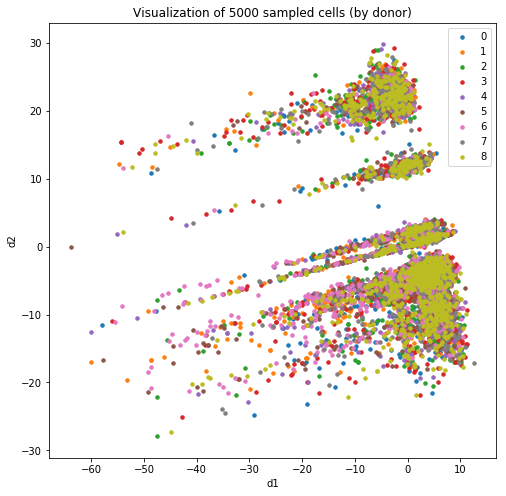

In [29]:
plt.figure(figsize=(8, 8))
for label in np.unique(batch_indices):
    plt.scatter(latent[batch_indices.ravel() == label, 0], latent[batch_indices.ravel() == label, 1], s=12)
#plt.legend(np.unique(kogene_labels))
plt.xlabel('d1');plt.ylabel('d2');plt.title('Visualization of 5000 sampled cells (by donor)')
plt.legend(np.unique(labels));
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/scvi_latent_space_donor.png', bbox='tight')

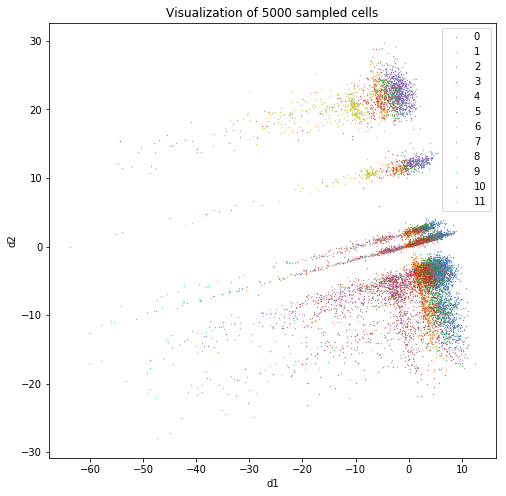

In [34]:
plt.figure(figsize=(8, 8))
for label in np.unique(labels):
    plt.scatter(latent[labels == label, 0], latent[labels == label, 1], s=0.1)
#plt.legend(np.unique(kogene_labels))
plt.xlabel('d1');plt.ylabel('d2');plt.title('Visualization of 5000 sampled cells')
plt.legend(np.unique(labels));
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/scvi_latent_space.png', bbox='tight')

### Sampling latent space - tSNE

In [45]:
kogene_latent, kogene_batch_indices, kogene_labels = get_cropseq_latent(kogene_model, data_loader['all'])

In [46]:
kogene_embedded = TSNE(n_components=2).fit_transform(kogene_latent)

Text(0.5,1,'tSNE of 5000 sampled cells (weighted)')

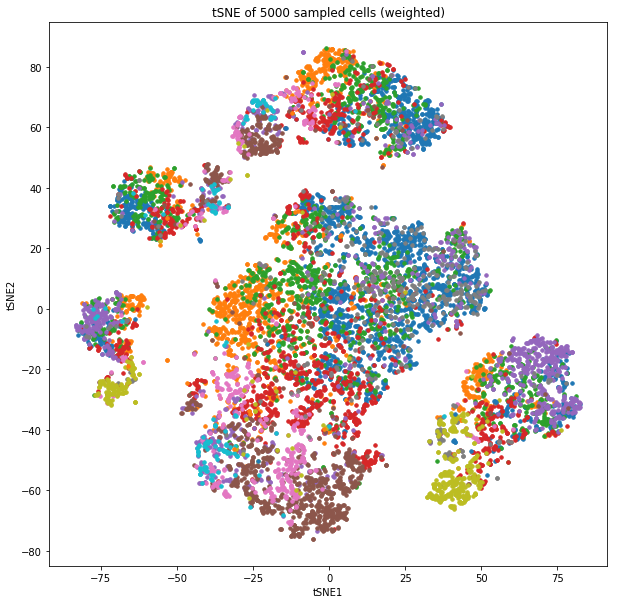

In [47]:
plt.figure(figsize=(10, 10))
for label in np.unique(kogene_labels):
    plt.scatter(kogene_embedded[kogene_labels == label, 0], kogene_embedded[kogene_labels == label, 1], s=12)
#plt.legend(np.unique(kogene_labels))
plt.xlabel('tSNE1');plt.ylabel('tSNE2');plt.title('tSNE of 5000 sampled cells (weighted)')